### Прогнозирование уровня средней заработной платы в России

In [100]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy import stats

import matplotlib.pyplot as plt
from tqdm import tqdm

from itertools import product

import warnings

import datetime
from dateutil.relativedelta import relativedelta

Загружаем данные из файла, конвертируем даты:

In [2]:
data = pd.read_csv("c:\\Users\\prokofyev\\Documents\\data-analysis-applications\\WAG_C_M.csv", sep=";", index_col="month",
                  parse_dates=["month"], dayfirst=True)

#### Визуальный анализ ряда:

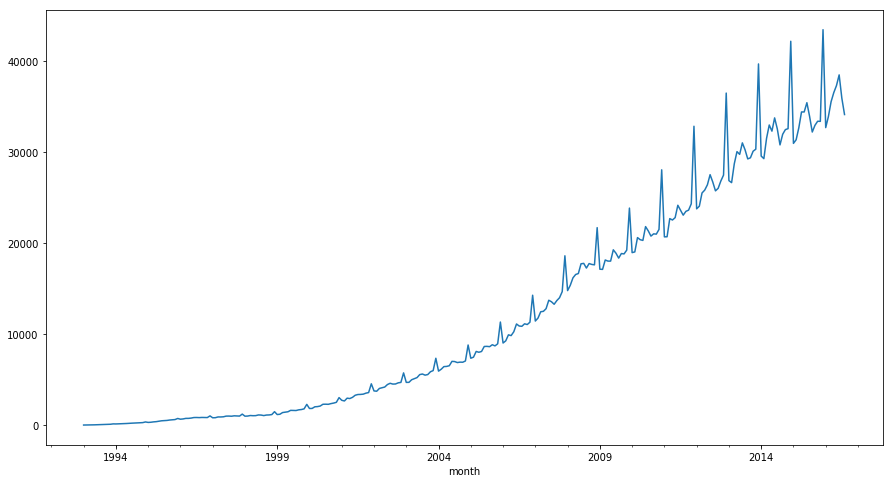

In [37]:
plt.figure(figsize=(15,8))
data.WAG_C_M.plot()

#### Стабилизация дисперсии:

In [4]:
data['WAG_C_M_box'], lmbda = stats.boxcox(data.WAG_C_M)

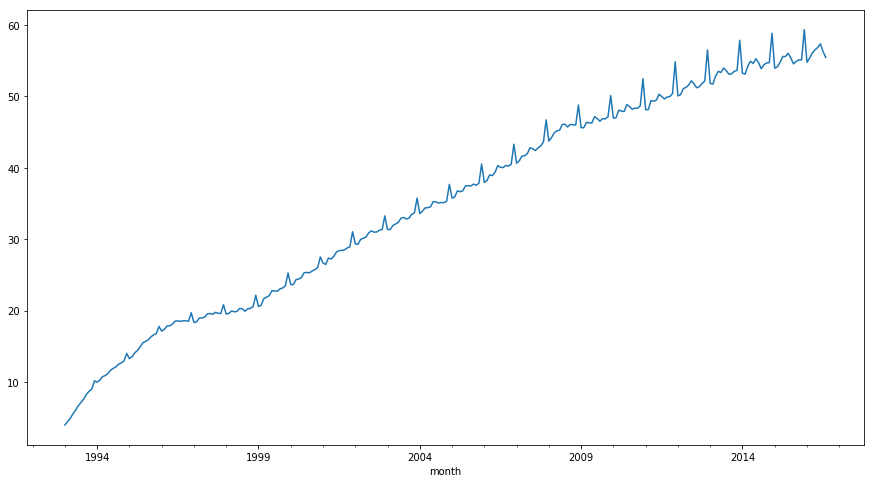

In [36]:
plt.figure(figsize=(15,8))
data.WAG_C_M_box.plot()

#### Выбор порядка дифференцирования:

Критерий Дики-Фуллера для оригинального ряда:

In [6]:
sm.tsa.stattools.adfuller(data.WAG_C_M_box)[1]

0.6968987634832688

Критерий Дики-Фуллера после сезонного дифференцирования:

In [7]:
data["WAG_C_M_box_diff"] = data.WAG_C_M_box - data.WAG_C_M_box.shift(12)

In [8]:
sm.tsa.stattools.adfuller(data.WAG_C_M_box_diff.dropna())[1]

0.014697133494791808

Критерий Дики-Фуллера после добавления обычного дифференцирования:

In [9]:
data["WAG_C_M_box_diff2"] = data.WAG_C_M_box_diff - data.WAG_C_M_box_diff.shift(1)

In [10]:
sm.tsa.stattools.adfuller(data.WAG_C_M_box_diff2.dropna())[1]

5.203603715821878e-08

После сезонного и обычного дифференцирования гипотеза нестационарности отвергается.

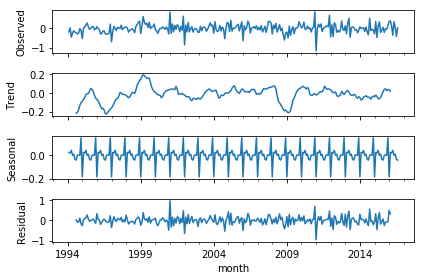

In [49]:
sm.tsa.seasonal_decompose(data.WAG_C_M_box_diff2.dropna()).plot()
plt.show()

Визуально остатки выглядят стационарными.

#### Выбор начальных приближений для p, q, P, Q

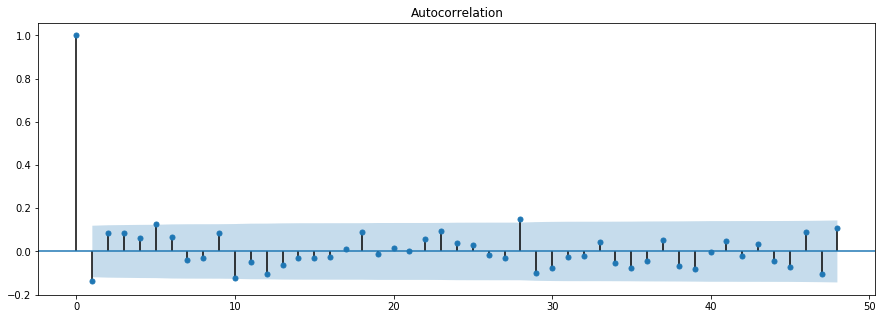

In [44]:
plt.figure(figsize=(15,5))
ax = plt.subplot(111)

sm.graphics.tsa.plot_acf(data.WAG_C_M_box_diff2.dropna().values.squeeze(), lags=48, ax=ax)
plt.show()

Начальные приближения Q=0, q=5

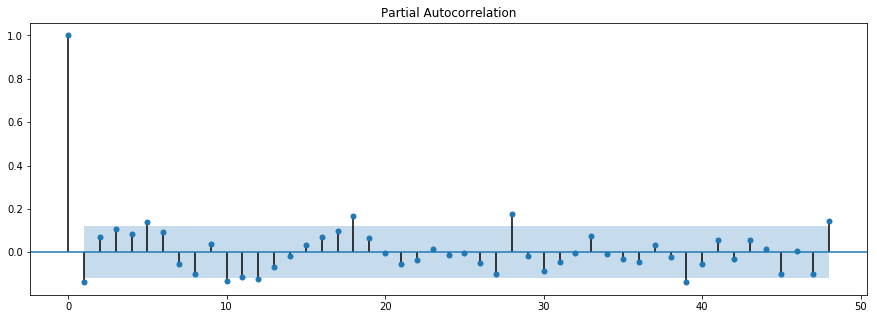

In [45]:
plt.figure(figsize=(15,5))
ax = plt.subplot(111)

sm.graphics.tsa.plot_pacf(data.WAG_C_M_box_diff2.dropna().values.squeeze(), lags=48, ax=ax)
plt.show()

Начальные приближения P=4, p=10

#### Обучение и сравнение моделей-кандидатов, выбор победителя

In [101]:
ps = range(0, 11)
d = 1
qs = range(0, 7)
Ps = range(0, 5)
D = 1
Qs = range(0, 2)

In [102]:
parameters = list(product(ps, qs, Ps, Qs))
len(parameters)

770

In [105]:
%%time

warnings.filterwarnings('ignore')

results = []
best_aic = float("inf")

for param in tqdm(parameters):
    try:
        model=sm.tsa.statespace.SARIMAX(data.WAG_C_M_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    except ValueError:
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

100%|██████████████████████████████████████████████████████████████████████████████| 770/770 [1:10:03<00:00,  5.46s/it]


Wall time: 1h 10min 3s


In [106]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
result_table.sort_values(by = 'aic', ascending=True).head()

,parameters,aic
279,"(4, 5, 4, 1)",-27.637079
289,"(4, 6, 4, 1)",-27.462430
149,"(2, 3, 4, 1)",-26.824615
239,"(3, 6, 4, 1)",-26.694617
312,"(5, 5, 1, 0)",-25.099843


#### Анализ остатков построенной модели

Критерий Стьюдента: p=0.498420
Критерий Дики-Фуллера: p=0.000000


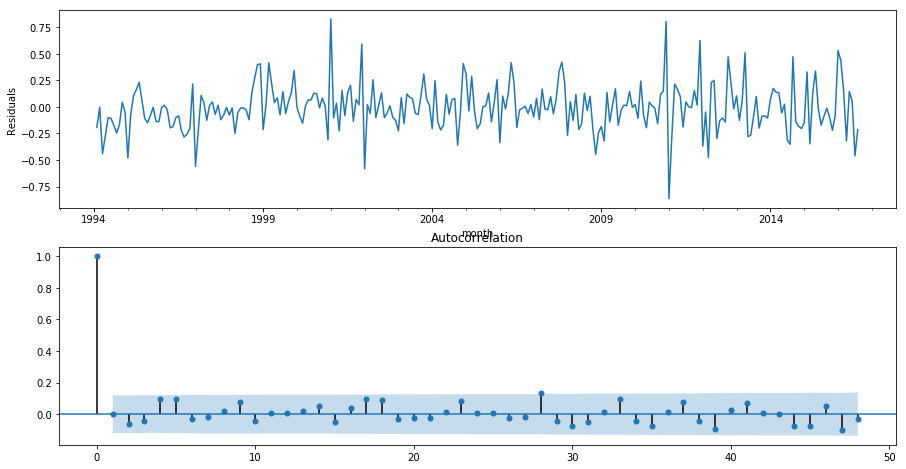

In [107]:
plt.figure(figsize=(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки стационарны, неавтокоррелированы, однако смещены:

In [108]:
off = best_model.resid[13:].mean()
off

-0.008942349408303187

In [109]:
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

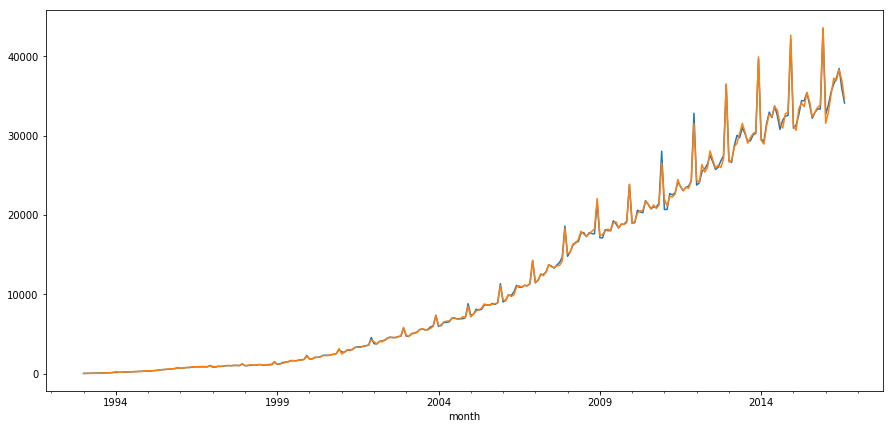

In [110]:
data['model'] = invboxcox(best_model.fittedvalues, lmbda) + off
plt.figure(figsize=(15,7))
data.WAG_C_M.plot()
data.model.plot()
plt.show()

#### Прогнозирование с помощью финальной модели

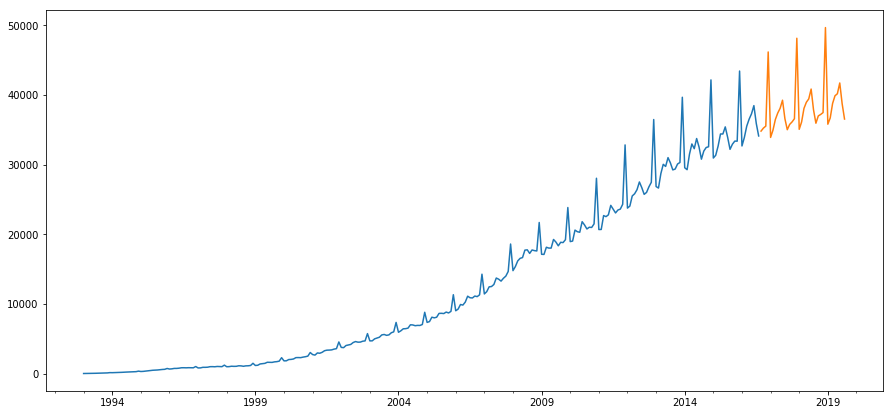

In [111]:
data2 = data[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2016-09-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns=data2.columns)
data2 = pd.concat([data2, future])
data2['forecast'] = invboxcox(best_model.predict(start=284, end=320), lmbda) + off

plt.figure(figsize=(15,7))
data2.WAG_C_M.plot()
data2.forecast.plot()
plt.show()